![](https://images.aicrowd.com/raw_images/challenges/banner_file/1021/e6d6bda6dc16f4905124.png)

<h2><center>Starter Code for Face Recognition</center></h2>


In this baseline we will be using basic [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)
 to compare the missing person image to all target faces ans generate our predictions. 

## Downloading Dataset

Installing puzzle datasets via `aicrowd-cli`

In [1]:
!pip install aicrowd-cli

# Make sure to re-run below code whenever you restart colab notebook

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Creating a new data directory and downloading the dataset 
!rm -rf data
!mkdir data
%aicrowd ds dl -c face-recognition -o data

%%bash
cd data
unzip data.zip

In [2]:
!ls data/

data.zip  missing  sample_submission.csv  target


# unzipping the data

!unzip data/data.zip -d data > /dev/null

## Importing Libraries

In [3]:
import pandas as pd
import os
import numpy as np
import random
from tqdm.notebook import tqdm
import cv2
import torch

random.seed(42)

from backbones import iresnet
import torch

In [4]:
#elasticface_model = iresnet.iresnet100()

In [5]:
#elasticface_model.load_state_dict(torch.load("elasticface_cos.pth"))

In [6]:
!mv /home/kuba/Downloads/elasticface_cos.pth .

mv: cannot stat '/home/kuba/Downloads/elasticface_cos.pth': No such file or directory


## Reading Dataset

In [7]:
# Getting all image ids from a folder

image_ids = os.listdir("data/missing")
len(image_ids)

1000

In [8]:
!ls data/

data.zip  missing  sample_submission.csv  target


In [9]:
import matplotlib.pyplot as plt

In [10]:
import pickle

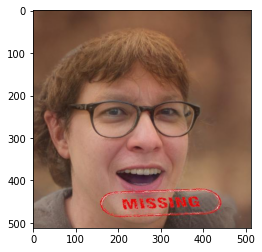

In [11]:
# Reading a sample missing person image


sample_image_id = random.choice(image_ids)
sample_image_id = '7kuz4.jpg'

sample_missing = cv2.imread(os.path.join("data/missing", sample_image_id))[:,:,[2,1,0]]
plt.imshow(sample_missing)

In [12]:
from skimage import filters

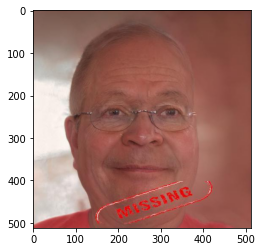

In [13]:
sample_image_id = '7kuz4.jpg'

sample_missing = cv2.imread(os.path.join("data/missing", image_ids[20]))[:,:,[2,1,0]]
plt.imshow(sample_missing)

In [14]:
def unwatermark_image(img, threshold=0.6):
    img = img.copy() / 255 
    pos_mask =  img[:,:,0] > threshold 
    neg_mask = (img[:,:,1:] < img.mean()).min(axis=-1)
    blurred_img = filters.gaussian(img, 50)
    img[pos_mask & neg_mask] = blurred_img[pos_mask & neg_mask]
    return img

<ipython-input-14-64ae217bb57a>:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  blurred_img = filters.gaussian(img, 50)


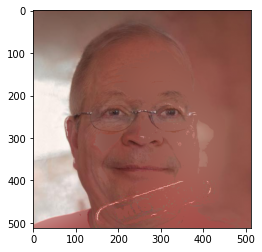

In [15]:
plt.imshow(unwatermark_image(sample_missing))

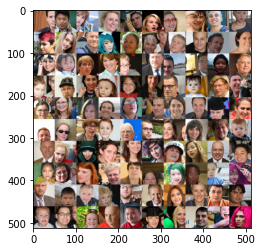

In [16]:
# Reading the corrosponding target faces

sample_target = cv2.imread(os.path.join("data/target", sample_image_id)) [:,:,[2,1,0]]
plt.imshow(cv2.resize(sample_target, (512, 512)))

In [17]:
# We can also split all the faces in the target image to convert them into individual faces images

sample_target_faces = []


def get_target_face(face_no, target_image):


  # Top-Left x, y corrdinates of the specific face 
  x, y = (int(face_no[0]))*216, (int(face_no[1]))*216
  target_face = target_image[x:x+216, y:y+216]

  return target_face

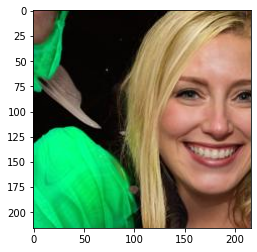

In [18]:
# Showing a sample face from a sample target image 

sample_target_face = get_target_face("96", sample_target)
plt.imshow(sample_target_face)

## Generating Predictions

In [19]:
from PIL import Image

In [20]:
type(Image.fromarray(sample_target_face))

PIL.Image.Image

In [21]:
from mlutil.feature_extraction import images as image_feature_extraction

In [22]:
from torchvision import models
import torch
from torch import nn
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
from torchvision import datasets
from sklearn import metrics
from skimage import util
import torch.nn.functional as F
from PIL import Image
from skimage import data
from skimage.feature import Cascade

from torch.utils import data

import matplotlib.pyplot as plt
from matplotlib import patches

import skimage.io
from torch.utils import data

from facenet_pytorch import MTCNN, InceptionResnetV1


resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet_children = list(resnet.children())

In [23]:
# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval()

In [24]:
truncated_model = nn.Sequential(*list(model.children())[:-4])

In [25]:
truncated_model.eval();

In [27]:
image_vectorizer = image_feature_extraction.TorchFeatureExtractor(
    truncated_model,
    appended_modules=[nn.Flatten()],
    normalize=transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    last_layer_index=None, use_gpu=True, last_nested_layer_index=None, img_size=160)

/home/kuba/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [29]:
img_id = image_ids[0]
target_image = cv2.imread(os.path.join("data/target", img_id))[:,:,[2,1,0]]

In [30]:
def get_imgs(target_image, preprocess=True):
    imgs = [
        target_image[i*216:(i+1)*216, 
        j*216:(j+1)*216]
        for i in range(10)
        for j in range(10)
    ]
    if preprocess:
        return torch.vstack([image_vectorizer.process_img(img) for img in imgs])
    else:
        return imgs

In [31]:
imgs = get_imgs(target_image)

In [32]:
used_model = image_vectorizer.model#image_vectorizer.model

In [33]:
target_image = skimage.io.imread(os.path.join("data/target", image_ids[0]))

In [34]:
missing_image = unwatermark_image(skimage.io.imread(os.path.join("data/missing", img_id)))

<ipython-input-14-64ae217bb57a>:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  blurred_img = filters.gaussian(img, 50)


In [35]:
missing_image = (unwatermark_image(skimage.io.imread(os.path.join("data/missing", img_id))) * 255).astype('uint8')

<ipython-input-14-64ae217bb57a>:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  blurred_img = filters.gaussian(img, 50)


In [36]:
image_vectorizer.process_img(missing_image).shape

torch.Size([1, 3, 160, 160])

In [37]:
used_model(image_vectorizer.process_img(missing_image)).shape

torch.Size([1, 1792])

In [38]:
from skimage import data
# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

In [39]:
import matplotlib.pyplot as plt

In [40]:
detector = Cascade(trained_file)

In [41]:
def crop_detected_face(img):
    min_size = int(img.shape[0] * 0.3)
    max_size = int(img.shape[0] * 0.9)
    detected = detector.detect_multi_scale(img=img,
                                           scale_factor=1.1,
                                           step_ratio=1,
                                           min_size=(min_size, min_size),
                                           max_size=(max_size, max_size))
    if len(detected) > 0:
        patch = detected[0]
        cropped = img[patch['r']:patch['r'] + patch['width'], patch['c']: patch['c'] + patch['height']]
        return cropped#(cropped * 255).astype("uint8")
    else:
        if img.dtype is float:
            return (cropped * 255).astype("uint8")
        else:
            return img

In [42]:
def get_missing_and_target(image_ids, do_crop=False):
    missing_images_cropped = []
    target_images_cropped = []
    for img_id in tqdm(image_ids):
        raw_missing_image = unwatermark_image(skimage.io.imread(os.path.join("data/missing", img_id)))
        if do_crop:
            missing_image = crop_detected_face(raw_missing_image)
            image_is_cropped = missing_image.mean() != raw_missing_image.mean()
        else:
            missing_image = raw_missing_image

        target_image = skimage.io.imread(os.path.join("data/target", img_id))
        imgs = [
            crop_detected_face(img) if image_is_cropped else img
            for img in 
            util.view_as_blocks(target_image, (216, 216, 3)).reshape(100, 216, 216, 3)
        ]
        torch_imgs = torch.cat([image_vectorizer.process_img(img) for img in imgs])

        missing_images_cropped.append(missing_image)
        target_images_cropped.append(torch_imgs.cpu())
    return missing_images_cropped, target_images_cropped

In [43]:
missing_images_cropped, target_images_cropped = get_missing_and_target(image_ids)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-14-64ae217bb57a>:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  blurred_img = filters.gaussian(img, 50)


In [44]:
len(image_ids)

1000

In [45]:
len(target_images_cropped)

1000

In [46]:
def get_predictions(image_ids, missing_images_cropped, target_images_cropped, metric='cosine'):
    predictions = {"ImageID":[], "target":[]}

    for img_id, missing_image, torch_imgs in tqdm(zip(image_ids, missing_images_cropped, target_images_cropped), total=len(missing_images_cropped)): 
        missing_torch_img = image_vectorizer.process_img(missing_image)
        missing_image_vector = used_model(missing_torch_img).cpu().numpy()

        target_vectors = used_model(torch_imgs.cuda()).cpu().numpy()
        similarities = metrics.pairwise_distances(missing_image_vector, target_vectors, metric=metric)[0]
        closest_face_no = similarities.argmin()

        predictions['ImageID'].append(img_id.replace(".jpg", ""))
        predictions['target'].append(closest_face_no)
    return pd.DataFrame(predictions)

In [ ]:

submission = get_predictions(image_ids, missing_images_cropped, target_images_cropped, metric='cosine')

In [122]:
i = 150

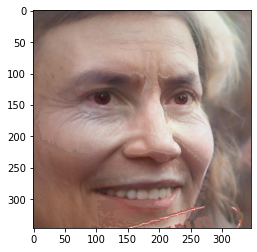

In [123]:
plt.imshow(missing_images_cropped[i])

In [124]:
found_target_img = target_images_cropped[i][submission['target'][i]].numpy().transpose([1,2,0])

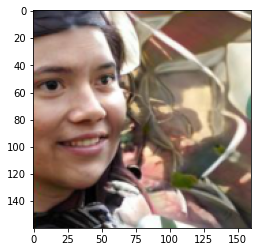

In [125]:
plt.imshow(found_target_img.astype('float'))

In [54]:
submission.head()

,ImageID,target
0,qkug9,5
1,0od55,80
2,3d874,29
3,teonh,36
4,hhne6,73


# Segmentation

In [70]:
from deepsense_vision.models.keypointrcnn.keypointrcnn_model import KeypointRCNNModel
from deepsense_vision.models.fasterrcnn.fasterrcnn_model import FasterRCNNModel
from deepsense_vision.models.maskrcnn.maskrcnn_model import MaskRCNNModel
import deepsense_vision

In [71]:
model = MaskRCNNModel()
model.load_from_zoo("coco")
model.to_gpu()

Loading from /home/kuba/.cache/deepsense_vision/maskrcnn-COCO.pt...
MaskRCNN loaded from /home/kuba/.cache/deepsense_vision/maskrcnn-COCO.pt successfully!


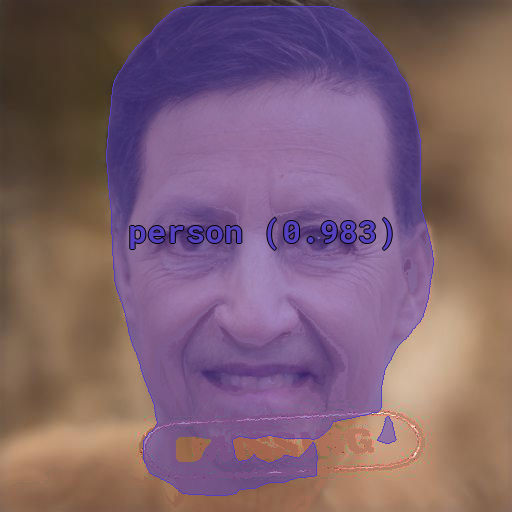

In [72]:
prediction = model.predict_from_array((missing_images_cropped[i] * 255).astype("uint8"))
prediction.visualize()

### Saving the Predictions

# Logging in from our AIcrowd account. Make sure you have accepted the puzzle rules before logging in!  


%load_ext aicrowd.magic
%aicrowd login

In [55]:
# Saving the predictions
!rm -rf submission/assets
!mkdir -p submission/assets
submission.to_csv(os.path.join("submission", "assets", "submission.csv"), index=False)

In [56]:
%%bash
pushd submission
rm submission.zip
cp ../baseline-face-recognition-dc9e45f8-3e3f-4040-886b-b6482fa98245.ipynb notebook.ipynb
zip -r submission.zip *
popd

~/Projects/aicrowd/blitzxiii/face_recognition/submission ~/Projects/aicrowd/blitzxiii/face_recognition
  adding: assets/ (stored 0%)
  adding: assets/submission.csv (deflated 38%)
  adding: notebook.ipynb (deflated 31%)
~/Projects/aicrowd/blitzxiii/face_recognition


In [57]:
!aicrowd submission create -c face-recognition -f submission/submission.zip

submission.zip ━━━━━━━━━━━━━━━━━━━━ 100.0% • 712.3/710.7 KB • 3.9 MB/s • 0:00:00 • 0:00:010:00:01
                                                   ╭─────────────────────────╮                                                   
                                                   │ Successfully submitted! │                                                   
                                                   ╰─────────────────────────╯                                                   
                                                         Important links                                                         
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition/submissions/175072              │
│                  │                                                                                                      

## Submitting our Predictions

In [56]:
%aicrowd notebook submit -c face-recognition -a assets --no-verify

UsageError: Line magic function `%aicrowd` not found.


Congratulations to making your first submission in the puzzle 🎉  . Let's continue with the journey by improving the baseline & making submission! Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in discussion forum or in AIcrowd Discord sever, AIcrew will be happy to help you :)

Have a cool new idea that you want to see in the next blitz ? Let us know!